# Study Power(Box-Cox) transform
* References

[Paper: Box and Cox(1964)](https://www.researchgate.net/publication/224839719_An_Analysis_of_Transformations_with_Discussion)

[StackExchange: llf of Box-Cox transform](https://stats.stackexchange.com/questions/261380/how-do-i-get-the-box-cox-log-likelihood-using-the-jacobian)

[Box-Cox Transformations: An Overview](https://www.ime.usp.br/~abe/lista/pdfm9cJKUmFZp.pdf)

[scipy code](https://github.com/scipy/scipy/blob/master/scipy/stats/morestats.py#L819)

[scipy API ref](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html#scipy.stats.boxcox)

[Concept: Korean](https://freshrimpsushi.github.io/posts/box-cox-transformation/)

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

from scipy.stats import boxcox, boxcox_llf, boxcox_normmax, f_oneway, shapiro, probplot, pearsonr, chi2
from scipy.optimize import brent, fsolve
from scipy.special import ndtri

# Load data

In [3]:
data = load_boston()

In [4]:
X = data['data']
y = data['target']

In [5]:
data['feature_names']

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

# EDA

In [6]:
corr = []
for col in range(X.shape[1]):
    corr.append(pearsonr(y, X[:,col])[0])
    print(str(col).zfill(2), np.unique(X[:,col]).size, corr[-1])

00 504 -0.3883046085868116
01 26 0.36044534245054327
02 76 -0.48372516002837296
03 2 0.17526017719029846
04 81 -0.4273207723732826
05 446 0.6953599470715395
06 356 -0.37695456500459623
07 412 0.24992873408590394
08 9 -0.3816262306397781
09 66 -0.4685359335677671
10 46 -0.507786685537562
11 357 0.3334608196570665
12 455 -0.737662726174015


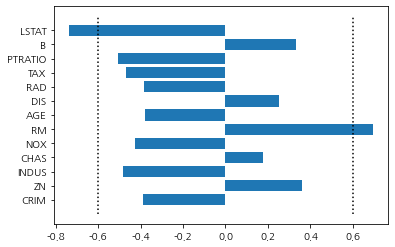

In [7]:
plt.barh(data['feature_names'], corr,)
plt.vlines(-.6, -1,13, linestyle=':', color='k')
plt.vlines(.6, -1,13, linestyle=':', color='k')
plt.show()

In [8]:
feat_num = 5
array = X[:,feat_num].copy()

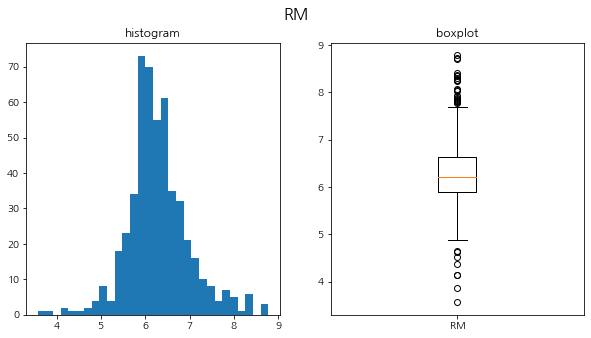

In [9]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
ax1.hist(array, bins=30)
ax1.set_title('histogram')
ax2 = fig.add_subplot(122)
ax2.boxplot(array, )
ax2.set_xticklabels([data['feature_names'][feat_num]])
ax2.set_title('boxplot')
fig.suptitle(data['feature_names'][feat_num], fontsize=16)
plt.show()

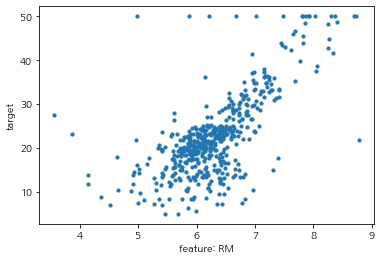

In [10]:
plt.scatter(array, y, s = 10)
plt.xlabel('feature: {}'.format(data['feature_names'][feat_num]))
plt.ylabel('target')
plt.show()

# Box-Cox

## Log likelihood function

* Approximately

$\large \displaystyle \begin{align*} l(\lambda) &= (\lambda - 1)\sum_{i}^{n} \log(x_i) - \frac{n}{2} \log(\mathrm{Var}(\mathbf{y})) \\
&= (\lambda - 1)\sum_{i}^{n} \log(x_i) - \frac{n}{2} \log(\frac{1}{n} \sum_{i}^{n}(y_i - \bar{y})^2) 
\end{align*}$ 

where $\large  \mathbf{y} = \begin{cases} \frac{\mathbf{x}^{\lambda} -1 }{\lambda}, &\lambda \ne 0\\ \log(\mathbf{x}), &\lambda = 0 \end{cases}$

In [11]:
lmbdas = np.linspace(-1,1, 100000)
llf = np.array([boxcox_llf(l, array) for l in lmbdas])

In [12]:
def _eval_mle(lmb, data):
    # refer to https://github.com/scipy/scipy/blob/master/scipy/stats/morestats.py#L1221
    return -boxcox_llf(lmb, data)

mx, my, _, _ = brent(_eval_mle, args = (array,), full_output=True, brack = (-2,2))

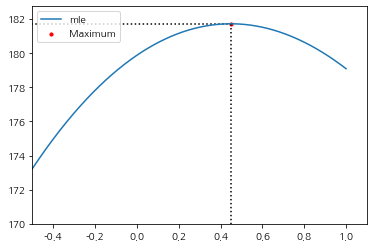

In [13]:
fig, ax = plt.subplots(1,1, )
ax.vlines(mx, -my, llf.min(), linestyle=':', color = 'k')
ax.hlines(-my, -1, mx, linestyle=':', color = 'k')
ax.plot(lmbdas, llf, label= 'mle')
ax.scatter(mx, -my, s=10, color='r', label = 'Maximum')
plt.xlim(-.5, None)
plt.ylim(170, None)
plt.legend()
plt.show()

* Confidence interval $100\times (1-\alpha)\%$  
  $\large \displaystyle llf(\lambda) > llf(\hat{\lambda}) - \frac{1}{2}\chi^2 (1 - \alpha, 1)$  
    where $\hat{\lambda}$ is lambda that maximizes the log-likelihood function and $\chi^2$ is a percent point function(quantile function) of chi-squared distribution.

In [14]:
alpha = 0.05
max_val = boxcox_llf(mx, array)
chi2_val = chi2.ppf(1 - alpha, 1) / 2

lmbdas[np.where(llf>max_val - chi2_val)[0]][0], lmbdas[np.where(llf>max_val - chi2_val)[0]][-1]

(-0.008570085700857044, 0.9185191851918519)

In [15]:
def llf_ci(lmb, data, mv, cv):
    return boxcox_llf(lmb, data) - mv + cv

fsolve(llf_ci, np.array([mx-1]), args=(array, max_val, chi2_val),)[0]

-0.00857915097458347

In [16]:
fsolve(llf_ci, np.array([mx-1]), args=(array, max_val, chi2_val),)[0], fsolve(llf_ci, np.array([mx+1]), args=(array, max_val, chi2_val),)[0]

(-0.00857915097458347, 0.9185208129274121)

In [17]:
boxcox(array, alpha=.05)[-1]

(-0.008579150974576498, 0.9185208129274042)

In [18]:
np.allclose((fsolve(llf_ci, np.array([mx-1]), args=(array, max_val, chi2_val),)[0], fsolve(llf_ci, np.array([mx+1]), args=(array, max_val, chi2_val),)[0]), 
           boxcox(array, alpha=.05)[-1])

True

* Finding the proper $\lambda$

In [19]:
lmbda_optimal = boxcox_normmax(array, method='all')
lmbda_optimal

array([0.55666267, 0.44895979])

```
lmbda_optimal[0]: by Pearson correlation coefficient
lmbda_optimal[1]: by mle
```

## Transformed data

In [20]:
array1, lmbda = boxcox(array)
print(lmbda)

0.4489597919730037


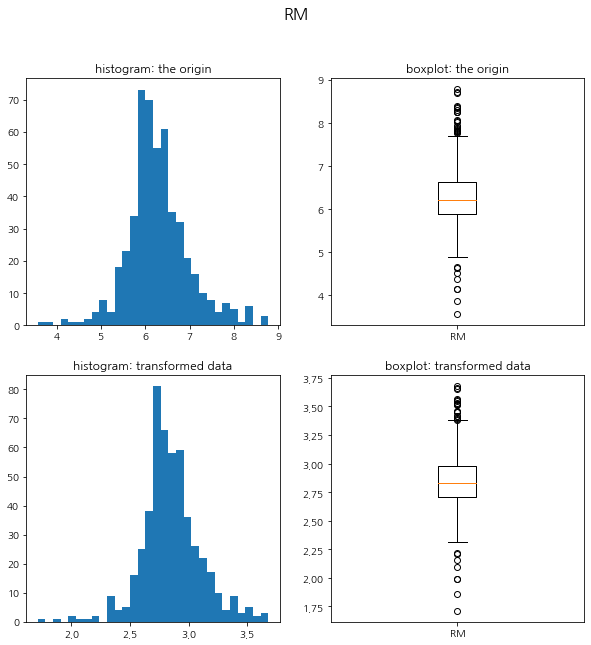

In [21]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(221)
ax1.hist(array, bins=30)
ax1.set_title('histogram: the origin')
ax2 = fig.add_subplot(222)
ax2.boxplot(array, )
ax2.set_xticklabels([data['feature_names'][feat_num]])
ax2.set_title('boxplot: the origin')


ax3 = fig.add_subplot(223)
ax3.hist(array1, bins=30)
ax3.set_title('histogram: transformed data')
ax4 = fig.add_subplot(224)
ax4.boxplot(array1, )
ax4.set_xticklabels([data['feature_names'][feat_num]])
ax4.set_title('boxplot: transformed data')

fig.suptitle(data['feature_names'][feat_num], fontsize=16)
plt.show()

In [22]:
def filliben(n):
    result = np.zeros(n)
    result[-1] = 0.5**(1./n)
    result[0] = 1 - 0.5**(1./n)
    for i in range(2, n):
        result[i-1] = (i - 0.3175) / (n + 0.365)
    return result

In [23]:
array_sc = np.sort(StandardScaler().fit_transform(array.reshape(-1,1)).flatten())
array1_sc = np.sort(StandardScaler().fit_transform(array1.reshape(-1,1)).flatten())
norm_ppf = ndtri(filliben(array.size))

In [24]:
val, sl = probplot(StandardScaler().fit_transform(array.reshape(-1,1)).flatten(), )

In [25]:
val1, sl1 = probplot(StandardScaler().fit_transform(array1.reshape(-1,1)).flatten(), )

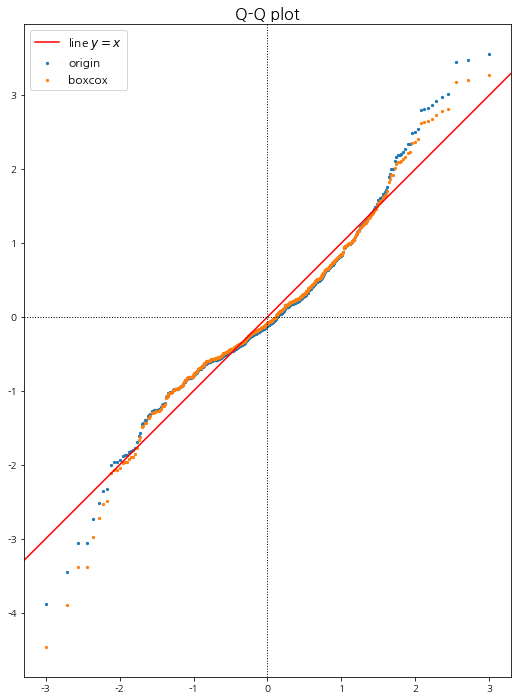

In [26]:
fig, ax = plt.subplots(1,1, figsize=(12,12))
ax.set_aspect(1)
ax.scatter(val[0], val[1], s=5, label='origin')
#ax.axline((0, sl[1]), slope=sl[0])
ax.scatter(val1[0], val1[1], s=5, label='boxcox')
#ax.axline((0, slope[1]), slope=slope[0], color = 'orange')
#ax.scatter(value[0], value[1], s=5, label='normal')
ax.axline((0,0), (1,1), color='r', label='line $y=x$')
ax.axline((0,0), (0,1), linestyle=':', linewidth=1, color='k')
ax.axline((0,0), (1,0), linestyle=':', linewidth=1, color='k')
plt.title('Q-Q plot', fontsize=16)
plt.legend(fontsize=12)
plt.show()

In [ ]:
# fig, ax = plt.subplots(1,1, figsize=(12,12))
# ax.set_aspect(1)
# ax.scatter(norm_ppf, array_sc, s=5, label='origin')
# ax.scatter(norm_ppf, array1_sc, s=5, label='boxcox')

# ax.axline((0,0), (1,1), color='r', label='line $y=x$')
# ax.axline((0,0), (0,1), linestyle=':', linewidth=1, color='k')
# ax.axline((0,0), (1,0), linestyle=':', linewidth=1, color='k')
# plt.title('Q-Q plot', fontsize=16)
# plt.legend(fontsize=12)
# plt.show()

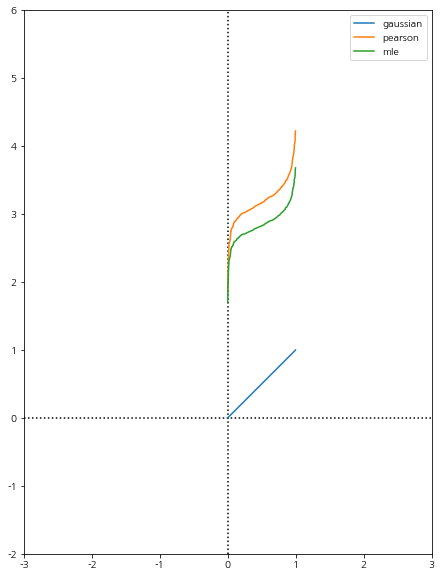

In [44]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.vlines(0., -2, 6, linestyle=':', color='k')
ax.hlines(0., -3, 3, linestyle=':', color='k')
ax.set_xlim(-3,3)
ax.set_ylim(-2,6)
ax.set_aspect(1)
#ax.plot(x,y,)
ax.plot(filliben(array.size), norm_ppf, label = 'gaussian')
ax.plot(filliben(array.size), np.sort(boxcox(array, lmbda = boxcox_normmax(array, method='all')[0])),  label='pearson' )
ax.plot(filliben(array.size), np.sort(boxcox(array, lmbda = boxcox_normmax(array, method='all')[1])),  label='mle' )
ax.legend()
plt.show()